**Imports Relevant Packages**

In [ ]:
!pip install beautifulsoup4
!pip install requests
!pip install timezonefinder
!pip install geopy

from bs4 import BeautifulSoup
import requests
import shutil
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
from datetime import timedelta
from timezonefinder import TimezoneFinder
from pytz import timezone

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.3 MB/s eta 0:00:00
  Created wheel for timezonefinder: filename=timezonefinder-6.2.0-cp310-cp310-manylinux_2_35_x86_64.whl size=46900632 sha256=5e564d725ebb110e858e70aaef2b144810e2ab46f6cc679b00a92fa3891b99b8
  Stored in directory: /root/.cache/pip/wheels/17/19/d4/ae94459b7f74f7e8f171862d1c08adedf9b7c76ddfc514a620
Successfully built timezonefinder


**Mounts local Google drive onto Colab notebook**

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


**Reads data from website, saves as text file, then loads website data from saved text file and assigns it to a Pandas dataframe**

In [ ]:
#Input parameters
dt_initial = '20230626'         #starting date YYYYMMDD format
dt_final = '20230630'           #final date YYYYMMDD format
season = 'spring'               #Available choices: spring, summer, autumn, winter, all
level = 1.5                     #AERONET data level
site = 'Tel-Aviv_University'                   #AERONET location
wavelength = [340,380,440,500,675,870,1020,1640]  #Available choices: 1640, 1020, 870, 865, 779, 675, 667, 620, 560, 555, 551, 532, 531, 510, 500, 490, 443, 440, 412, 400, 380, 340
Angstrom_exp = '440-870'        #Available choices: '440-870','380-500','440-675','500-870','340-440','440-675'

#Reads data from website with user parameters, saves as text file,
#then loads website data from saved text file and assigns it to a Pandas dataframe

yr_initial = dt_initial[:4]               #initial year
mon_initial = dt_initial[4:6]             #initial month
day_initial = dt_initial[6:]              #initial day

yr_final = dt_final[:4]                   #final year
mon_final = dt_final[4:6]                 #final month
day_final = dt_final[6:]                  #final day

if level == 1 or level == 1.0:
  level = 10
elif level == 1.5:
  level = 15
elif level == 2 or level == 2.0:
  level = 20

base_web = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site=',site,'&year=',yr_initial,'&month=',mon_initial,'&day=',day_initial,'&year2=',yr_final,'&month2=',mon_final,'&day2=',day_final,'&AOD',level,'=1&AVG=10'

def convertTuple(tup):
  st = ''.join(map(str, tup))
  return st

url = convertTuple(base_web)
soup = BeautifulSoup(requests.get(url).text)

if len(soup) <= 1:
  site = 'GSFC'
  print("\nThe link could not be generated due to issues with the input. Using system defaults...")
  print("Site: GSFC. Level: 2.0. Dates: 2000-01-01 to 2022-12-31")
  base_web = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site=GSFC&year=2000&month=01&day=01&year2=2022&month2=12&day2=31&AOD20=1&AVG=10'
  url = convertTuple(base_web)
  soup = BeautifulSoup(requests.get(url).text)

with open(r'/content/sample_data/Test.txt' ,"w") as oFile:
  oFile.write(str(soup.text))
  oFile.close()

**Data processing - Time**

In [ ]:
df = pd.read_csv(r'/content/sample_data/Test.txt',skiprows = 5) #reads data into Pandas dataframe
df = df.replace(-999.0, np.nan)             #replaces all -999.9 values with NaN so that averages are properly calculated

df[['Day','Month','Year']] = df['Date(dd:mm:yyyy)'].str.split(':',expand=True)                            #splits Date column into separate columns
df['Date'] = df[['Year','Month','Day']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")   #joins those columns back in a different format
df['Date']= pd.to_datetime(df['Date'])                                                                    #converts Date column to datetime format for easier manipulation

def tz_diff(date, tz1, tz2):              #Returns the difference in hours between timezone1 and timezone2 for a given date.
  date = pd.to_datetime(date)
  return (tz1.localize(date) -
            tz2.localize(date).astimezone(tz1))\
            .seconds/3600

diff = tz_diff('2000-01-01',timezone('UTC'), timezone(TimezoneFinder().timezone_at(lng=pd.unique(df[['Site_Longitude(Degrees)']].values.ravel('K'))[0],
                                            lat=pd.unique(df[['Site_Latitude(Degrees)']].values.ravel('K'))[0])))    #computes the time difference between site and GMT based on coordinates
if diff > 12:
  diff = diff-24          #this correction converts time difference range from 0-24 hours to [-12, +12] hours

df.insert(3,"Time_Diff", diff)                                       #inserts blank column that will store the computed time difference between GMT and the local time at that location

df['Time(hh:mm:ss)'] = pd.to_datetime(df['Time(hh:mm:ss)'],infer_datetime_format=True).apply(lambda d:d.time()) #converts time column from string to timestamp, keeping just the hours
df['GMT'] = df.apply(lambda x : pd.datetime.combine(x['Date'],x['Time(hh:mm:ss)']),1)          #combines date and time together into one timestamp in GMT

df.insert(1,"LST", 0)     #Inserts a new local time column
for i in range(len(df)):
  df['LST'][i] = df['GMT'][i] + timedelta(hours = int(df['Time_Diff'][i]))   #calculates local standard time based on time zone difference from GMT

**Calculating Local Solar Time**

In [ ]:
#local solar time = local standard time (daylight savings not included) + 4*(Lst - Lloc) + E
#E = 229.2(0.000075 + 0.001868 𝑐𝑜𝑠 𝐵 − 0.032077 𝑠𝑖𝑛 𝐵 − 0.014615 𝑐𝑜𝑠 2𝐵 − 0.04089 𝑠𝑖𝑛 2𝐵); can also be interpolated graphically
#B = (n-1)*(360/365)       where n is day of the year 1<=n<=365

#Lst is the standard meridian for the local time zone, calculated as x*15,
#where 'x' is the hour difference between GMT and local standard time, and 15 is the number of degrees corresponding per hour.

#Lloc is the longitude of the location in question

#E is the equation of time in minutes

#Source: https://faculty.eng.ufl.edu/jonathan-scheffe/wp-content/uploads/sites/100/2020/08/Solar-Time1419.pdf

df['B'] = np.nan
for i in range(len(df)):                                      #calculates B parameter
  df['B'][i] = (df['Day_of_Year'][i]-1)*(360/365)

df['E'] = np.nan
for i in range(len(df)):                                      #calculates equation of time in minutes
  df['E'][i] = 229.2*(0.000075 + 0.001868*math.cos(df['B'][i]) - 0.032077*math.sin(df['B'][i]) - 0.014615*math.cos(2*df['B'][i]) - 0.04089*math.sin(2*df['B'][i]))

df['Lst'] = np.nan
for i in range(len(df)):                                      #calculates standard meridian
  df['Lst'][i] = 15*abs(df['GMT'][i] - df['LST'][i]).total_seconds()/3600

df['Correction'] = np.nan
for i in range(len(df)):                                      #calculates time difference between solar time and local standard time
  df['Correction'][i] = 4*(df['Lst'][i] - abs(df['Site_Longitude(Degrees)'][i])) + df['E'][i]

df['Timestamp (solar)'] = np.nan
for i in range(len(df)):                                      #calculates local solar time as datetime stamp
  df['Timestamp (solar)'][i] = (df['LST'][i] + timedelta(hours=0, minutes=df['Correction'][i])).strftime("%Y-%m-%d %H:%M:%S")

**Creating the hourly bins**

In [ ]:
df['Date_Solar'] = pd.to_datetime(df['Timestamp (solar)']).dt.date
df['Hour'] = np.nan

for i in range(len(df)):
  df['Hour'][i] = df['GMT'][i].strftime('%H:%M:%S')   #isolates the hours, minutes and seconds from the solar timestamp
  df['Hour'][i] = df['Hour'][i][:-6]     #populates new Hour column with the times by truncating the last 6 characters of the old time column, leaving just the hour

df1 = df[['Date_Solar','Hour','Time(hh:mm:ss)']]
for i in range(len(wavelength)):
  df1['AOD_'+str(wavelength[i])+'nm'] = df['AOD_'+str(wavelength[i])+'nm']
df1[Angstrom_exp+'_Angstrom_Exponent'] = df[Angstrom_exp+'_Angstrom_Exponent']
df1['Precipitable_Water(cm)'] = df['Precipitable_Water(cm)']
df = df1.rename(columns={"Date_Solar": "Date", "Time(hh:mm:ss)": "Time"})

df['Date'] = pd.to_datetime(df['Date'])
df['Daily_Occurence'] = df.groupby('Date')['Date'].transform('size')              #creates new Daily Occurence column, which counts number of records for each day
df

,Date,Hour,Time,AOD_340nm,AOD_380nm,AOD_440nm,AOD_500nm,AOD_675nm,AOD_870nm,AOD_1020nm,AOD_1640nm,440-870_Angstrom_Exponent,Precipitable_Water(cm),Daily_Occurence
0,2023-06-26,04,04:13:53,0.242333,0.223856,0.193822,0.167055,0.114335,0.082695,NaN,0.040830,1.255214,1.467350,92
1,2023-06-26,06,06:06:34,0.244615,0.219290,0.186936,0.158071,0.102021,0.075267,0.060092,0.035374,1.352438,1.635029,92
2,2023-06-26,06,06:15:57,0.187391,0.166482,0.133827,0.110513,0.070972,0.050285,0.042070,0.025697,1.440817,1.557441,92
3,2023-06-26,06,06:31:27,0.198484,0.175135,0.141604,0.116535,0.075006,0.053688,0.044795,0.028156,1.427185,1.644100,92
4,2023-06-26,06,06:33:25,0.200622,0.177117,0.143742,0.118892,0.076285,0.054166,0.044625,0.027953,1.437735,1.626404,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,2023-06-30,15,15:12:38,0.295514,0.267050,0.228777,0.197598,0.137143,0.102852,0.087522,0.058332,1.180449,1.949361,79
386,2023-06-30,15,15:44:44,0.311344,0.281559,0.241642,0.208507,0.144085,0.107320,0.091340,0.059227,1.198222,1.897963,79
387,2023-06-30,15,15:47:43,0.284597,0.254973,0.213637,0.184591,0.126281,0.094392,0.080082,0.052068,1.209629,1.881932,79
388,2023-06-30,15,15:53:04,0.298937,0.269103,0.228631,0.197457,0.135466,0.100427,0.084255,0.055071,1.216093,1.894213,79


**Season Selection**

In [ ]:
df['Season'] = (df['Date'].dt.month - 1) // 3
if season == 'winter':
  df = df.loc[df['Season'] == 0]
elif season == 'spring':
  df = df.loc[df['Season'] == 1]
elif season == 'summer':
  df = df.loc[df['Season'] == 2]
elif season == 'autumn' or season == 'fall':
  df = df.loc[df['Season'] == 3]
df = df.drop(columns = ['Season']).reset_index(drop=True)
df

,Date,Hour,Time,AOD_340nm,AOD_380nm,AOD_440nm,AOD_500nm,AOD_675nm,AOD_870nm,AOD_1020nm,AOD_1640nm,440-870_Angstrom_Exponent,Precipitable_Water(cm),Daily_Occurence
0,2023-06-26,04,04:13:53,0.242333,0.223856,0.193822,0.167055,0.114335,0.082695,NaN,0.040830,1.255214,1.467350,92
1,2023-06-26,06,06:06:34,0.244615,0.219290,0.186936,0.158071,0.102021,0.075267,0.060092,0.035374,1.352438,1.635029,92
2,2023-06-26,06,06:15:57,0.187391,0.166482,0.133827,0.110513,0.070972,0.050285,0.042070,0.025697,1.440817,1.557441,92
3,2023-06-26,06,06:31:27,0.198484,0.175135,0.141604,0.116535,0.075006,0.053688,0.044795,0.028156,1.427185,1.644100,92
4,2023-06-26,06,06:33:25,0.200622,0.177117,0.143742,0.118892,0.076285,0.054166,0.044625,0.027953,1.437735,1.626404,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,2023-06-30,15,15:12:38,0.295514,0.267050,0.228777,0.197598,0.137143,0.102852,0.087522,0.058332,1.180449,1.949361,79
386,2023-06-30,15,15:44:44,0.311344,0.281559,0.241642,0.208507,0.144085,0.107320,0.091340,0.059227,1.198222,1.897963,79
387,2023-06-30,15,15:47:43,0.284597,0.254973,0.213637,0.184591,0.126281,0.094392,0.080082,0.052068,1.209629,1.881932,79
388,2023-06-30,15,15:53:04,0.298937,0.269103,0.228631,0.197457,0.135466,0.100427,0.084255,0.055071,1.216093,1.894213,79


**Visualizing how many measurements are taken per day. It appears that most commonly, there are 50-60 daily measurements at GSFC.**

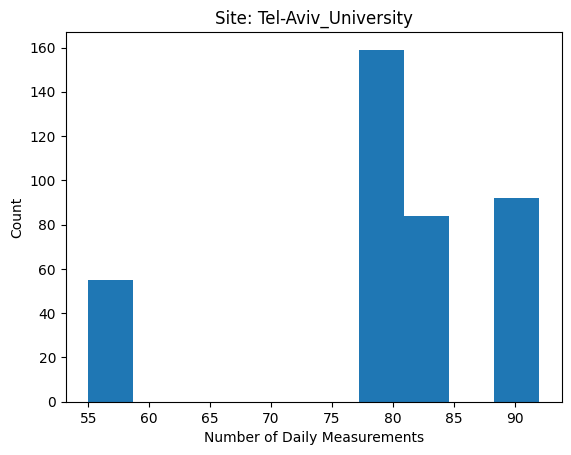

In [ ]:
plt.hist(df['Daily_Occurence'])
plt.xlabel('Number of Daily Measurements')
plt.ylabel('Count')
plt.title("Site: "+str(site))
plt.show()

**If number of measurements per day >10 compute Daily Average (e.g., AOD_500, AE (440-870), WVC)**

In [ ]:
df_averaged = df[df['Daily_Occurence'] >= 10]    #creates new dataframe that only contains records having more than 10 occurrences per day
df_averaged = df_averaged.reset_index(drop = True).drop(columns='Daily_Occurence') #resets index and removes Daily Occurence column

df_daily = df.groupby('Date').mean().reset_index().drop(columns='Daily_Occurence') #creates a new dataframe with just daily averages, whose values will be used to compute absolute differences

for i in range(len(wavelength)): #renames the wavelength columns to daily
  df_daily = df_daily.rename(columns={'AOD_'+str(wavelength[i])+'nm':'AOD_'+str(wavelength[i])+'nm_Daily'})
df_daily = df_daily.rename(columns={Angstrom_exp+'_Angstrom_Exponent':Angstrom_exp+'_Angstrom_Exponent_Daily','Precipitable_Water(cm)':'Precipitable_Water(cm)_Daily'}) #renames remainder of columns to daily

df_combined = pd.merge(df_averaged, df_daily, on='Date')              #merges daily data frame with the concatenated dataframe from above
df_combined

,Date,Hour,Time,AOD_340nm,AOD_380nm,AOD_440nm,AOD_500nm,AOD_675nm,AOD_870nm,AOD_1020nm,...,AOD_340nm_Daily,AOD_380nm_Daily,AOD_440nm_Daily,AOD_500nm_Daily,AOD_675nm_Daily,AOD_870nm_Daily,AOD_1020nm_Daily,AOD_1640nm_Daily,440-870_Angstrom_Exponent_Daily,Precipitable_Water(cm)_Daily
0,2023-06-26,04,04:13:53,0.242333,0.223856,0.193822,0.167055,0.114335,0.082695,NaN,...,0.175936,0.152193,0.120847,0.100154,0.064422,0.046852,0.038508,0.025587,1.395057,1.417680
1,2023-06-26,06,06:06:34,0.244615,0.219290,0.186936,0.158071,0.102021,0.075267,0.060092,...,0.175936,0.152193,0.120847,0.100154,0.064422,0.046852,0.038508,0.025587,1.395057,1.417680
2,2023-06-26,06,06:15:57,0.187391,0.166482,0.133827,0.110513,0.070972,0.050285,0.042070,...,0.175936,0.152193,0.120847,0.100154,0.064422,0.046852,0.038508,0.025587,1.395057,1.417680
3,2023-06-26,06,06:31:27,0.198484,0.175135,0.141604,0.116535,0.075006,0.053688,0.044795,...,0.175936,0.152193,0.120847,0.100154,0.064422,0.046852,0.038508,0.025587,1.395057,1.417680
4,2023-06-26,06,06:33:25,0.200622,0.177117,0.143742,0.118892,0.076285,0.054166,0.044625,...,0.175936,0.152193,0.120847,0.100154,0.064422,0.046852,0.038508,0.025587,1.395057,1.417680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,2023-06-30,15,15:12:38,0.295514,0.267050,0.228777,0.197598,0.137143,0.102852,0.087522,...,0.230448,0.204791,0.168533,0.144054,0.099790,0.077379,0.066945,0.046953,1.151235,1.921551
386,2023-06-30,15,15:44:44,0.311344,0.281559,0.241642,0.208507,0.144085,0.107320,0.091340,...,0.230448,0.204791,0.168533,0.144054,0.099790,0.077379,0.066945,0.046953,1.151235,1.921551
387,2023-06-30,15,15:47:43,0.284597,0.254973,0.213637,0.184591,0.126281,0.094392,0.080082,...,0.230448,0.204791,0.168533,0.144054,0.099790,0.077379,0.066945,0.046953,1.151235,1.921551
388,2023-06-30,15,15:53:04,0.298937,0.269103,0.228631,0.197457,0.135466,0.100427,0.084255,...,0.230448,0.204791,0.168533,0.144054,0.099790,0.077379,0.066945,0.046953,1.151235,1.921551


**For each hourly bin compute absolute differences, instantaneous values minus daily average (e.g., for AOD_500, AE(440-870), WVC)**

In [ ]:
for i in range(len(wavelength)):
  df_combined['Absolute_Diff_AOD'+str(wavelength[i])] = np.nan    #creates blank columns, which represent the absolute differences for AOD, 440-870 Angstrom, WVC

df_combined['Absolute_Diff_'+str(Angstrom_exp)] = np.nan
df_combined['Absolute_Diff_WVC'] = np.nan

for i in range(len(df_combined)):      #calculates absolute differences between instantaneous (hourly) bins and daily values.
  for j in range(len(wavelength)):
    df_combined['Absolute_Diff_AOD'+str(wavelength[j])][i] = df_combined['AOD_'+str(wavelength[j])+'nm'][i] - df_combined['AOD_'+str(wavelength[j])+'nm_Daily'][i]

  df_combined['Absolute_Diff_'+str(Angstrom_exp)][i] = df_combined[Angstrom_exp+'_Angstrom_Exponent'][i] - df_combined[Angstrom_exp+'_Angstrom_Exponent_Daily'][i]
  df_combined['Absolute_Diff_WVC'][i] = df_combined['Precipitable_Water(cm)'][i] - df_combined['Precipitable_Water(cm)_Daily'][i]

df_combined

,Date,Hour,Time,AOD_340nm,AOD_380nm,AOD_440nm,AOD_500nm,AOD_675nm,AOD_870nm,AOD_1020nm,...,Absolute_Diff_AOD340,Absolute_Diff_AOD380,Absolute_Diff_AOD440,Absolute_Diff_AOD500,Absolute_Diff_AOD675,Absolute_Diff_AOD870,Absolute_Diff_AOD1020,Absolute_Diff_AOD1640,Absolute_Diff_440-870,Absolute_Diff_WVC
0,2023-06-26,04,04:13:53,0.242333,0.223856,0.193822,0.167055,0.114335,0.082695,NaN,...,0.066397,0.071663,0.072975,0.066901,0.049913,0.035843,NaN,0.015243,-0.139843,0.049670
1,2023-06-26,06,06:06:34,0.244615,0.219290,0.186936,0.158071,0.102021,0.075267,0.060092,...,0.068679,0.067097,0.066089,0.057917,0.037599,0.028415,0.021584,0.009787,-0.042619,0.217349
2,2023-06-26,06,06:15:57,0.187391,0.166482,0.133827,0.110513,0.070972,0.050285,0.042070,...,0.011455,0.014289,0.012980,0.010359,0.006550,0.003433,0.003562,0.000110,0.045760,0.139761
3,2023-06-26,06,06:31:27,0.198484,0.175135,0.141604,0.116535,0.075006,0.053688,0.044795,...,0.022548,0.022942,0.020757,0.016381,0.010584,0.006836,0.006287,0.002569,0.032128,0.226420
4,2023-06-26,06,06:33:25,0.200622,0.177117,0.143742,0.118892,0.076285,0.054166,0.044625,...,0.024686,0.024924,0.022895,0.018738,0.011863,0.007314,0.006117,0.002366,0.042678,0.208724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,2023-06-30,15,15:12:38,0.295514,0.267050,0.228777,0.197598,0.137143,0.102852,0.087522,...,0.065066,0.062259,0.060244,0.053544,0.037353,0.025473,0.020577,0.011379,0.029214,0.027810
386,2023-06-30,15,15:44:44,0.311344,0.281559,0.241642,0.208507,0.144085,0.107320,0.091340,...,0.080896,0.076768,0.073109,0.064453,0.044295,0.029941,0.024395,0.012274,0.046987,-0.023588
387,2023-06-30,15,15:47:43,0.284597,0.254973,0.213637,0.184591,0.126281,0.094392,0.080082,...,0.054149,0.050182,0.045104,0.040537,0.026491,0.017013,0.013137,0.005115,0.058394,-0.039619
388,2023-06-30,15,15:53:04,0.298937,0.269103,0.228631,0.197457,0.135466,0.100427,0.084255,...,0.068489,0.064312,0.060098,0.053403,0.035676,0.023048,0.017310,0.008118,0.064858,-0.027338


**Old algorithm - DO NOT EXECUTE**

In [ ]:
df_absolute = df_combined.filter(regex='Absolute')
df_combined = df_combined[['Date','Hour']]
df_combined = pd.concat([df_combined,df_absolute], axis=1)

df_combined['Hour'] = df_combined['Hour'].astype(int)
df_combined.insert(0,"N_Diff",1)
df_N_diff = df_combined[['N_Diff','Hour']]
df_N_diff = df_N_diff.groupby(['Hour'],sort=False)['N_Diff'].sum().reset_index()

df_combined = df_combined.drop(columns=['Date','N_Diff'])

df_stdev = df_combined.groupby(['Hour'],sort=False).std().reset_index()
df_miu = df_combined.groupby(['Hour'],sort=False).mean().reset_index()

for i in range(len(wavelength)):
  df_stdev = df_stdev.rename(columns={'Absolute_Diff_AOD'+str(wavelength[i]):'AOD_'+str(wavelength[i])+'nm_Sigma'})
  df_miu = df_miu.rename(columns={'Absolute_Diff_AOD'+str(wavelength[i]):'AOD_'+str(wavelength[i])+'nm_Miu'})

df_stdev = df_stdev.rename(columns={'Absolute_Diff_'+str(Angstrom_exp):Angstrom_exp+'_Sigma','Absolute_Diff_WVC':'WVC_Sigma'})
df_miu = df_miu.rename(columns={'Absolute_Diff_'+str(Angstrom_exp):Angstrom_exp+'_Miu','Absolute_Diff_WVC':'WVC_Miu'})
df_statistics = pd.merge(df_stdev, df_miu)

df_final = df_statistics.drop_duplicates()
df_diurnal = pd.merge(df_final,df_N_diff)
df_diurnal.to_excel(r'/content/sample_data/Output_'+str(site)+'_OLD.xlsx',index=False)   #saves table as Excel file

**For each hourly bin compute mean of those differences and corresponding standard deviations**

In [ ]:
df_absolute = df_combined.filter(regex='Absolute')
df_combined = df_combined[['Date','Hour']]
df_combined = pd.concat([df_combined,df_absolute], axis=1)

df_stdev = df_combined.groupby(['Date','Hour']).std().reset_index()
df_miu = df_combined.groupby(['Date','Hour']).mean().reset_index()

for i in range(len(wavelength)):
  df_stdev = df_stdev.rename(columns={'Absolute_Diff_AOD'+str(wavelength[i]):'AOD_'+str(wavelength[i])+'nm_Sigma'})
  df_miu = df_miu.rename(columns={'Absolute_Diff_AOD'+str(wavelength[i]):'AOD_'+str(wavelength[i])+'nm_Miu'})

df_stdev = df_stdev.rename(columns={'Absolute_Diff_'+str(Angstrom_exp):Angstrom_exp+'_Sigma','Absolute_Diff_WVC':'WVC_Sigma'})
df_miu = df_miu.rename(columns={'Absolute_Diff_'+str(Angstrom_exp):Angstrom_exp+'_Miu','Absolute_Diff_WVC':'WVC_Miu'})
df_statistics = pd.merge(df_stdev, df_miu)
df_statistics

,Date,Hour,AOD_340nm_Sigma,AOD_380nm_Sigma,AOD_440nm_Sigma,AOD_500nm_Sigma,AOD_675nm_Sigma,AOD_870nm_Sigma,AOD_1020nm_Sigma,AOD_1640nm_Sigma,...,AOD_340nm_Miu,AOD_380nm_Miu,AOD_440nm_Miu,AOD_500nm_Miu,AOD_675nm_Miu,AOD_870nm_Miu,AOD_1020nm_Miu,AOD_1640nm_Miu,440-870_Miu,WVC_Miu
0,2023-06-26,04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.066397,0.071663,0.072975,0.066901,0.049913,0.035843,NaN,0.015243,-0.139843,0.049670
1,2023-06-26,06,0.019605,0.018455,0.018530,0.016568,0.010824,0.008615,0.006240,0.003070,...,0.026223,0.026980,0.025420,0.021431,0.013650,0.009246,0.007774,0.003322,0.023445,0.209745
2,2023-06-26,07,0.021816,0.018251,0.021202,0.018746,0.011126,0.007425,0.005747,0.004175,...,0.029777,0.024337,0.023978,0.020172,0.012529,0.008774,0.007229,0.005849,0.017087,0.286563
3,2023-06-26,08,0.005476,0.004283,0.003590,0.003028,0.002673,0.002131,0.002430,0.001958,...,0.015973,0.014458,0.008440,0.007060,0.004801,0.004714,0.004233,0.004603,-0.033970,0.219768
4,2023-06-26,09,0.009559,0.008497,0.006782,0.005832,0.003746,0.002784,0.003171,0.002156,...,-0.004744,-0.005441,-0.008106,-0.006864,-0.003808,-0.001390,-0.001117,0.000919,-0.052207,0.080208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2023-06-30,11,0.016410,0.015160,0.014163,0.012479,0.007856,0.005934,0.005915,0.003645,...,0.005013,0.003065,0.002833,0.004003,0.006633,0.008349,0.009220,0.007845,-0.128494,-0.052021
57,2023-06-30,12,0.023227,0.022030,0.022991,0.020511,0.013360,0.009838,0.007436,0.005497,...,0.008883,0.008350,0.011505,0.012582,0.012728,0.012671,0.012218,0.010107,-0.127982,-0.076109
58,2023-06-30,13,0.013256,0.010941,0.003082,0.004239,0.001541,0.001180,0.001731,0.001096,...,0.034987,0.034141,0.028493,0.027839,0.022423,0.018737,0.018709,0.012573,-0.087054,-0.069124
59,2023-06-30,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.046821,0.043784,0.040883,0.036755,0.028486,0.021610,0.019115,0.012984,-0.046561,-0.031860


**Final Table should look like this**

In [ ]:
df_final = df_statistics.fillna(0)                                    #fills remaining NaNs with zeroes. Any zero indicates that there was only 1 record for a particular hourly bin and/or day so a calculated average
df_final['Hour'] = df_final['Hour'].astype(int)       #cuts zero from hourly bin column and then converts to string
df_final = df_final.drop(columns=['Date'])
df_final.insert(len(df_final.columns),"N_Diff",1)
df_N_Diff = df_final.groupby(['Hour'])['N_Diff'].sum().reset_index() #sums all number of differences per given hour
df_final = df_final.drop(columns=['N_Diff'])
df_final = df_final.groupby(['Hour']).mean().reset_index()   #takes average of all means and standard deviations per given hour
df_diurnal = pd.merge(df_final,df_N_Diff)
df_diurnal.to_excel(r'/content/sample_data/Output_'+str(site)+'_NEW.xlsx',index=False)   #saves table as Excel file

**Creating Diurnal Plots**

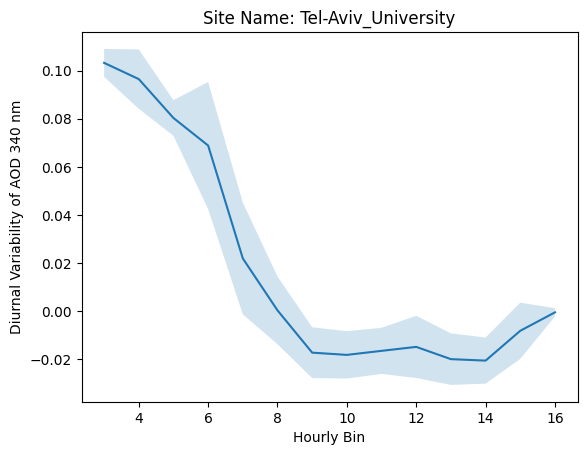

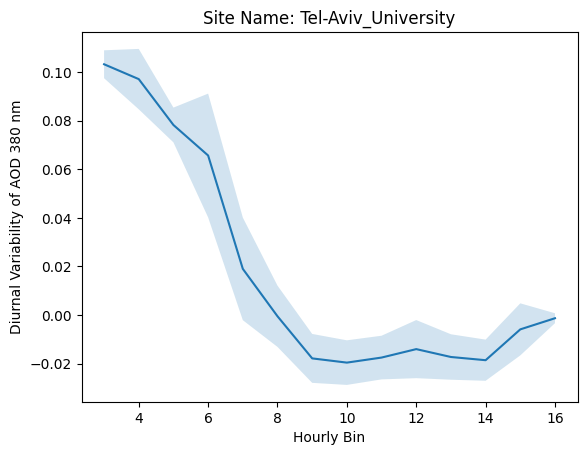

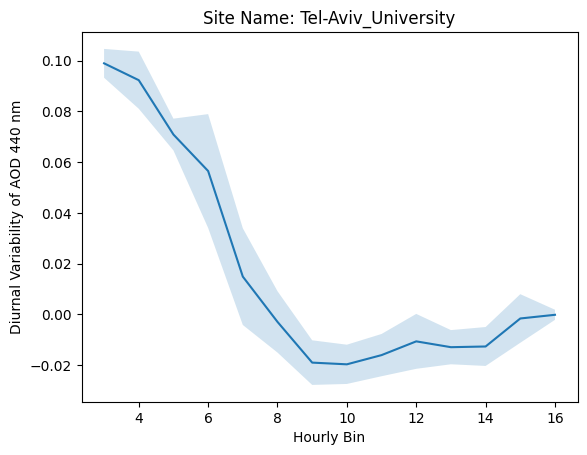

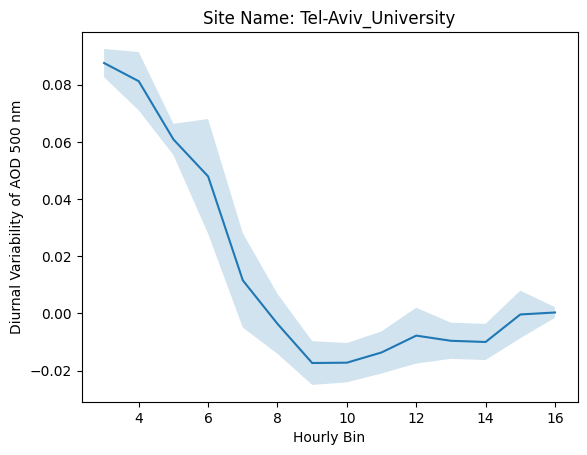

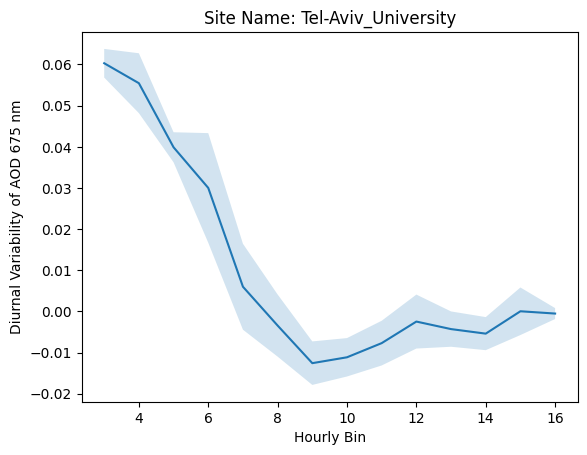

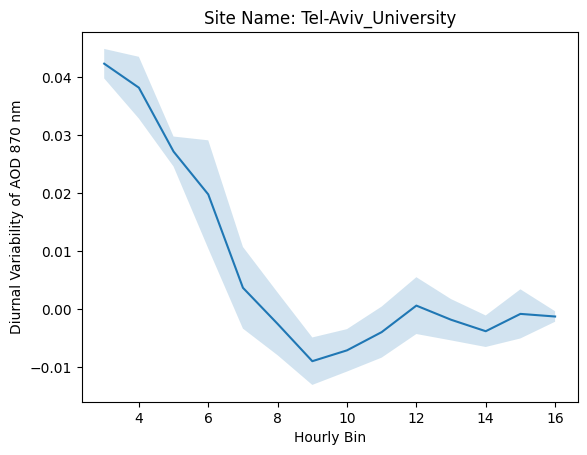

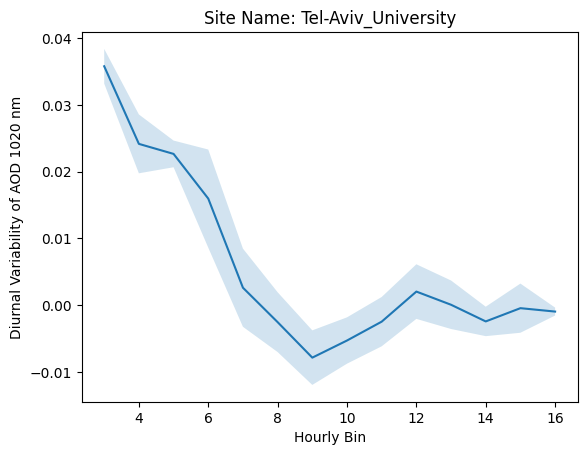

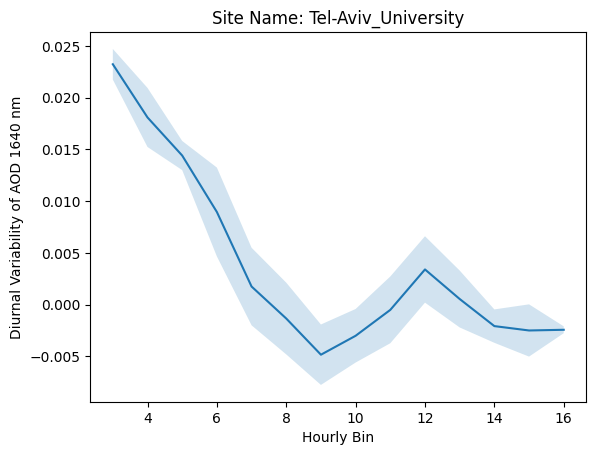

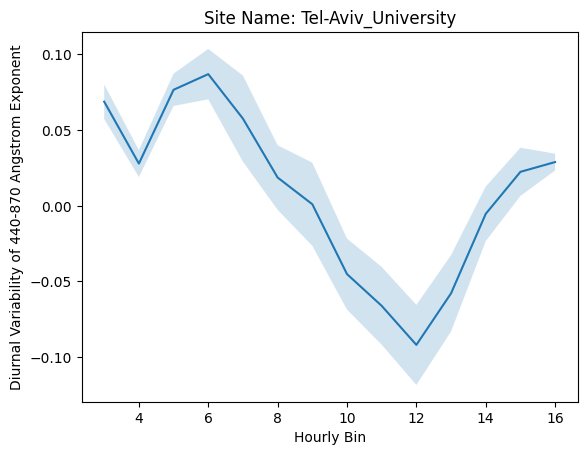

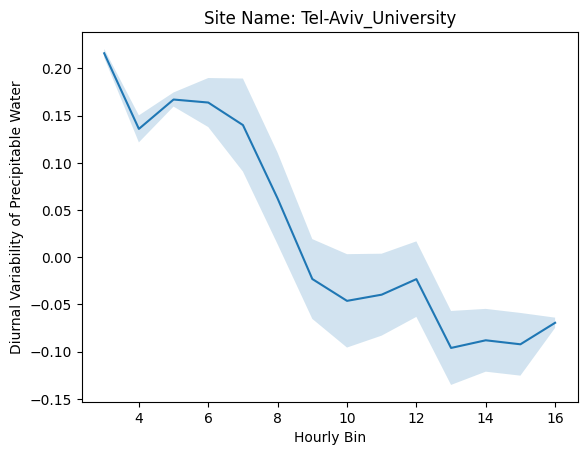

In [ ]:
for i in range(len(wavelength)):
  plt.plot(df_diurnal['Hour'], df_diurnal['AOD_'+str(wavelength[i])+'nm_Miu'])
  plt.xlabel('Hourly Bin')
  plt.ylabel('Diurnal Variability of AOD '+str(wavelength[i])+' nm')
  plt.title("Site Name: "+str(site))
  plt.fill_between(df_diurnal['Hour'], df_diurnal['AOD_'+str(wavelength[i])+'nm_Miu']-df_diurnal['AOD_'+str(wavelength[i])+'nm_Sigma'], df_diurnal['AOD_'+str(wavelength[i])+'nm_Miu']+df_diurnal['AOD_'+str(wavelength[i])+'nm_Sigma'], alpha = 0.2)
  plt.show()

plt.plot(df_diurnal['Hour'], df_diurnal[Angstrom_exp+'_Miu'])
plt.xlabel('Hourly Bin')
plt.ylabel('Diurnal Variability of '+str(Angstrom_exp)+' Angstrom Exponent')
plt.title("Site Name: "+str(site))
plt.fill_between(df_diurnal['Hour'], df_diurnal[Angstrom_exp+'_Miu']-df_diurnal[Angstrom_exp+'_Sigma'], df_diurnal[Angstrom_exp+'_Miu']+df_diurnal[Angstrom_exp+'_Sigma'], alpha = 0.2)
plt.show()

plt.plot(df_diurnal['Hour'], df_diurnal['WVC_Miu'])
plt.xlabel('Hourly Bin')
plt.ylabel('Diurnal Variability of Precipitable Water')
plt.title("Site Name: "+str(site))
plt.fill_between(df_diurnal['Hour'], df_diurnal['WVC_Miu']-df_diurnal['WVC_Sigma'], df_diurnal['WVC_Miu']+df_diurnal['WVC_Sigma'], alpha = 0.2)
plt.show()